# A short tutorial on adversarial attacks
### Accompanies 'Adversarial attacks in deep learning: what can they teach us?' – Veronika Samborska
### (based on a tensorflow 2 tutorial)

### Import packages

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Load pre-trained deep convolutional network (MobileNetV2)

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper functions

In [9]:
# Helper function to pre-process the image so that it can be provided as input to MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image,(224,224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

# Plot images
def display_images(image, description):
    _,label,confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,label, confidence*100))
    plt.show()

# Define network loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()


### Select your image (change path to change image)

In [4]:
image_path = tf.keras.utils.get_file('spaniel,','https://www.rover.com/blog/wp-content/uploads/2019/11/springer-spaniel-via-pixabay-960x540.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

### Plot example image

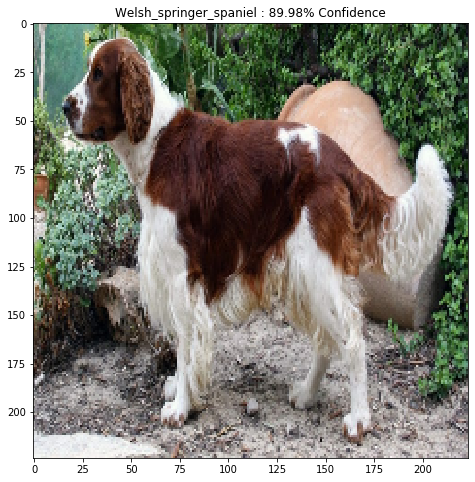

In [5]:
plt.rcParams['figure.figsize'] = (20,8)
plt.figure()
plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

### Generate adversarial noise

In [6]:
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label,prediction)
    gradient = tape.gradient(loss,input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad


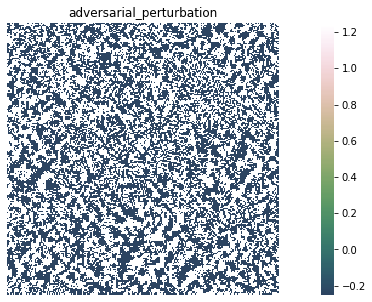

In [10]:
# Get the input label for the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations_ = create_adversarial_pattern(image, label)
perturbations = perturbations_[0]*0.75+0.5
plt.rcParams['figure.figsize'] = (15,5)
cmap_matrix = sns.cubehelix_palette(start=.5, rot=-1, dark=0.25, light=1, reverse=True, as_cmap=True, n_colors=10)
sns.heatmap(perturbations[:,:,0],cmap=cmap_matrix,square=True)
plt.xticks([])
plt.yticks([])
plt.title('adversarial_perturbation');

### Influence of adversarial attack on image classification
The network initially outputs a correct prediction for the input image, but this rapidly degrades into dramatic and non-human errors, as $\epsilon$ (the magnitude of the adversarial perturbation) increases.

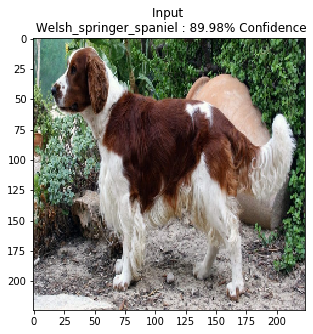

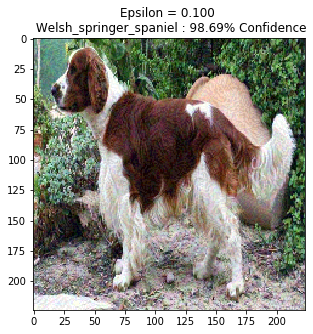

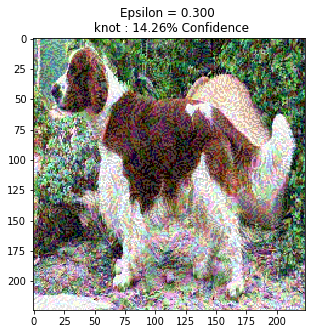

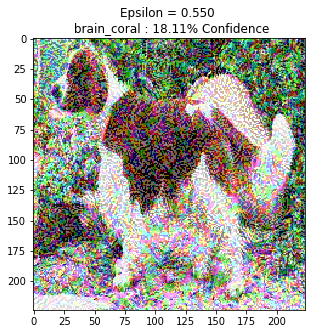

In [8]:
epsilons = [0, 0.1, 0.3, 0.55]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

plt.rcParams['figure.figsize'] = (20,5)
for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])


### References:

<ul>
    <li>https://arxiv.org/abs/1312.6199
    <li>https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
    <li>https://arxiv.org/abs/1602.02697
<ul/>